<a href="https://colab.research.google.com/github/ytg000629/ai4dl/blob/main/project/BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 라이브러리 설치,import, 데이터 준비



In [ ]:
!pip install keras_preprocessing
!pip install emoji
!pip install autocorrect

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 1.8 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 355.8/355.8 kB 7.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for emoji: filename=emoji-2.5.0-py2.py3-none-any.whl size=351211 sha256=4ef1f36c6bd516441f1481bf4ef22cbde8b94c23eb9dae085c6384b9a7030612
  Stored in directory: /root/.cache/pip/wheels/2a/0c/2c/07b5af72b120503fe24590691d24c462a25e5e530db8700a96
Successfully built emoji
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 622.8/622.8 kB 10.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for autocorrect: filename=autocorrect-2.6.1-py3-none-any.whl size=622363 sha25

In [ ]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import emoji

from nltk.util import ngrams
from sklearn.feature_extraction.text import CountVectorizer
from collections import defaultdict
from wordcloud import WordCloud
from wordcloud import STOPWORDS
from collections import  Counter
plt.style.use('ggplot')

import re
from nltk.tokenize import word_tokenize
import wordcloud
import gensim
import string
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences #keras_preprocessing

from tqdm import tqdm
from keras.models import Sequential
from keras.layers import Embedding,LSTM,Dense,SpatialDropout1D, SimpleRNN, Bidirectional
from keras.initializers import Constant
from sklearn.model_selection import train_test_split

import os 
import warnings
warnings.filterwarnings(action  = 'ignore')

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.initializers import TruncatedNormal
from tensorflow.keras.losses import CategoricalCrossentropy,BinaryCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy,BinaryAccuracy
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model

from autocorrect import Speller 

In [ ]:
#%config Completer.use_jedi = False

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df_train = pd.read_csv('drive/MyDrive/nlp-getting-started/train.csv')
df_test = pd.read_csv('drive/MyDrive//nlp-getting-started/test.csv')
df_sample = pd.read_csv('drive/MyDrive//nlp-getting-started/sample_submission.csv')

In [ ]:
df_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [ ]:
df_train.shape

(7613, 5)

In [ ]:
df_test.shape

(3263, 4)

In [ ]:
df_test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


# 데이터 전처리

In [ ]:
#불용어 사전 정의
stop=set(stopwords.words('english'))

#spell check 진행 정도 파악을 위
tqdm.pandas()

def text_preproccessing(df):  
    
    df = df.copy()
    
    # URL 제거
    def remove_URL(text):
        url = re.compile(r'https?://\S+|www\.\S+')
        return url.sub(r'',text)

    # HTML tag 제거
    def remove_html(text):
        html=re.compile(r'<.*?>')
        return html.sub(r'',text)

    # 구두점 제거
    def remove_punct(text):
        table=str.maketrans('','',string.punctuation)
        return text.translate(table)

    # 이모티콘 제거
    def remove_emoji(text):
        emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               "]+", flags=re.UNICODE)
        return emoji_pattern.sub(r'', text)

    # 불용어 제거
    def remove_stopwords(x):
        return ' '.join([i for i in x.split() if i not in stop])


    # 스펠링 교정
    def spell_check(x):
        spell = Speller(lang='en')
        return " ".join([spell(i) for i in x.split()])


    df['text']=df['text'].apply(lambda x : remove_URL(x))
    df['text']=df['text'].apply(lambda x : remove_html(x))
    df['text']=df['text'].apply(lambda x : remove_punct(x))
    df['text']=df['text'].apply(lambda x : remove_emoji(x))
    df['text']=df['text'].apply(lambda x : remove_stopwords(x))
    #df['text']=df['text'].progress_apply(lambda x : spell_check(x))


    return df

In [ ]:
df_train = text_preproccessing(df_train)
df_test = text_preproccessing(df_test)

#50분 정도 소요

In [ ]:
df_train.shape

(7613, 6)

In [ ]:
df_train.head()

,id,keyword,location,text,target,length
0,1,NaN,NaN,Our Deeds Reason earthquake May ALLAH Forgive us,1,69
1,4,NaN,NaN,Forest fire near La Ronge Sask Canada,1,38
2,5,NaN,NaN,All residents asked shelter place notified off...,1,133
3,6,NaN,NaN,13000 people receive wildfires evacuation orde...,1,65
4,7,NaN,NaN,Just got sent photo Ruby Alaska smoke wildfire...,1,88


In [ ]:
df_test.shape

(3263, 4)

In [ ]:
df_test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened terrible car crash
1,2,NaN,NaN,Heard earthquake different cities stay safe ev...
2,3,NaN,NaN,forest fire spot pond geese fleeing across str...
3,9,NaN,NaN,Apocalypse lighting Spokane wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 China Taiwan


In [ ]:
df=pd.concat([df_train,df_test])
df.shape

(10876, 6)

# BERT

In [ ]:
from transformers import AutoTokenizer, TFBertModel
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
bert = TFBertModel.from_pretrained('bert-base-uncased')

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [ ]:
#train_data, val_data, train_labels, val_labels = train_test_split(df_train.text.values, df_train.target.values, test_size=0.2, random_state=10)
train_data, val_data, train_labels, val_labels = train_test_split(df['text'][:df_train.shape[0]].values, df_train['target'].values, test_size=0.2, stratify=df_train['target'].values, random_state=10)

In [ ]:
max_length = 34

In [ ]:
train_data = tokenizer(
    text = train_data.tolist(),
    add_special_tokens = True,
    max_length = max_length,
    truncation = True,
    padding = True,
    return_tensors = 'tf',
    return_token_type_ids = False,
    return_attention_mask = True,
    verbose = True
    
)

In [ ]:
train_data

{'input_ids': <tf.Tensor: shape=(6090, 34), dtype=int32, numpy=
array([[  101,  2610,  3102, ...,     0,     0,     0],
       [  101,  1049,  2232, ...,     0,     0,     0],
       [  101, 11352,  5856, ...,     0,     0,     0],
       ...,
       [  101, 12632,  3521, ...,     0,     0,     0],
       [  101,  2017,  4148, ...,     0,     0,     0],
       [  101,  2018,  3167, ...,     0,     0,     0]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(6090, 34), dtype=int32, numpy=
array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]], dtype=int32)>}

In [ ]:
val_data = tokenizer(
    text = val_data.tolist(),
    add_special_tokens = True,
    max_length = max_length,
    truncation = True,
    padding = True,
    return_tensors = 'tf',
    return_token_type_ids = False,
    return_attention_mask = True,
    verbose = True
    
)

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import TruncatedNormal
from tensorflow.keras.losses import CategoricalCrossentropy,BinaryCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy,BinaryAccuracy
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model

In [ ]:
max_len = 34


input_ids = keras.Input(shape = (max_len,), dtype = tf.int32, name = 'input_ids')
input_mask = keras.Input(shape = (max_len,), dtype = tf.int32, name = 'input_mask')

embeddings = bert([input_ids, input_mask])[1]

out = Dense(128, activation='relu')(embeddings)
out = tf.keras.layers.Dropout(0.5)(out)
y = Dense(1,activation = 'sigmoid')(out)
    
model = tf.keras.Model(inputs=[input_ids, input_mask], outputs=y)
model.layers[2].trainable = True

In [ ]:
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 34)]         0           []                               
                                                                                                  
 input_mask (InputLayer)        [(None, 34)]         0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    multiple             109482240   ['input_ids[0][0]',              
                                                                  'input_mask[0][0]']             
                                                                                                  
 dense_2433 (Dense)             (None, 128)          98432       ['tf_bert_model[4][1]']    

In [ ]:
train_data['input_ids']

<tf.Tensor: shape=(6090, 34), dtype=int32, numpy=
array([[  101,  2610,  3102, ...,     0,     0,     0],
       [  101,  1049,  2232, ...,     0,     0,     0],
       [  101, 11352,  5856, ...,     0,     0,     0],
       ...,
       [  101, 12632,  3521, ...,     0,     0,     0],
       [  101,  2017,  4148, ...,     0,     0,     0],
       [  101,  2018,  3167, ...,     0,     0,     0]], dtype=int32)>

In [ ]:
from keras.optimizers import Adam
optimizer = Adam(
    learning_rate=6e-06, # this learning rate is for bert model , taken from huggingface website 
    epsilon=1e-08,
    decay=0.01,
    clipnorm=1.0)

loss = BinaryCrossentropy(from_logits = True)

metric = BinaryAccuracy('accuracy')


model.compile(
    optimizer = optimizer,
    loss = loss, 
    metrics = metric)

callbacks_list = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_accuracy',                    
        patience=3                               
    ),
    tf.keras.callbacks.ModelCheckpoint(                
        filepath="checkpoint_path.keras",        
        monitor='val_accuracy',                          
        save_best_only=True,                       
        verbose=1                                   
    )
]

In [ ]:
history = model.fit(
    x ={'input_ids':train_data['input_ids'],'input_mask':train_data['attention_mask']} ,
    y = train_labels,
    validation_data = ({'input_ids':val_data['input_ids'],'input_mask':val_data['attention_mask']},val_labels),
    callbacks=callbacks_list,
    epochs=20,
    batch_size=64
)

Epoch 1/20
96/96 [==============================] - ETA: 0s - loss: 0.4318 - accuracy: 0.8279
Epoch 1: val_accuracy improved from -inf to 0.83191, saving model to checkpoint_path.keras
96/96 [==============================] - 101s 623ms/step - loss: 0.4318 - accuracy: 0.8279 - val_loss: 0.4202 - val_accuracy: 0.8319
Epoch 2/20
96/96 [==============================] - ETA: 0s - loss: 0.3566 - accuracy: 0.8691
Epoch 2: val_accuracy improved from 0.83191 to 0.83651, saving model to checkpoint_path.keras
96/96 [==============================] - 58s 610ms/step - loss: 0.3566 - accuracy: 0.8691 - val_loss: 0.4256 - val_accuracy: 0.8365
Epoch 3/20
96/96 [==============================] - ETA: 0s - loss: 0.3412 - accuracy: 0.8773
Epoch 3: val_accuracy did not improve from 0.83651
96/96 [==============================] - 48s 497ms/step - loss: 0.3412 - accuracy: 0.8773 - val_loss: 0.4263 - val_accuracy: 0.8365
Epoch 4/20
96/96 [==============================] - ETA: 0s - loss: 0.3231 - accuracy

In [ ]:
loaded_model = tf.keras.models.load_model('checkpoint_path.keras', custom_objects={"TFBertModel": TFBertModel})

In [ ]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

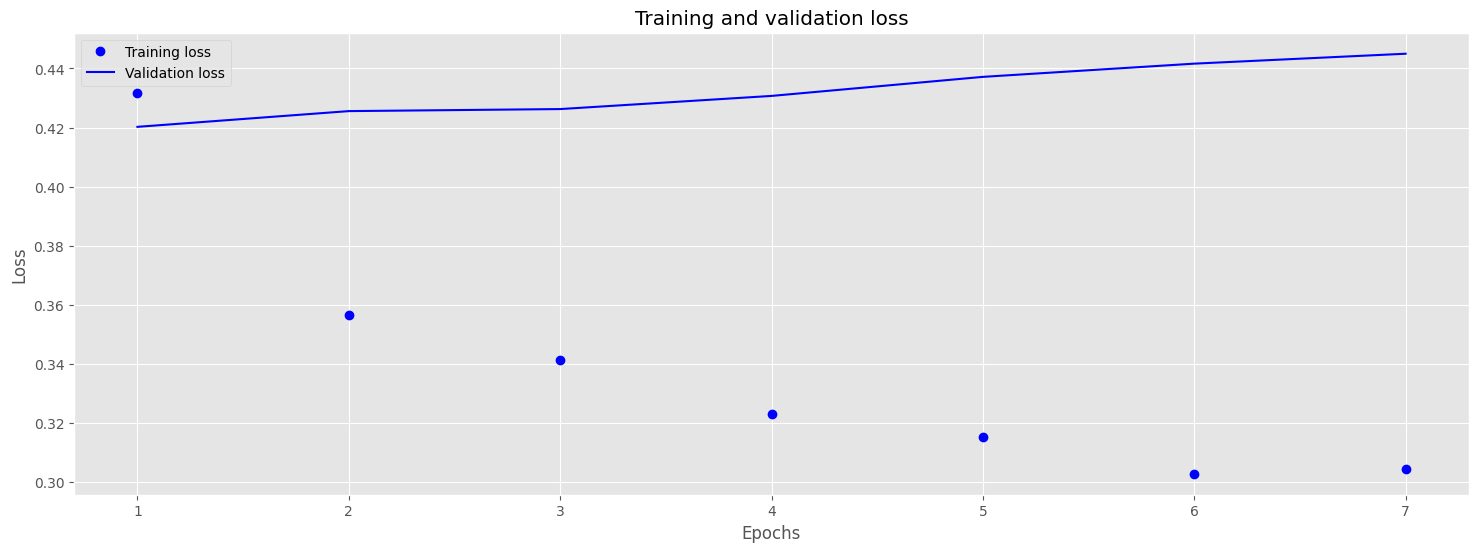

In [ ]:
history_dict = history.history
loss_values = history_dict["loss"]
val_loss_values = history_dict["val_loss"]
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, "bo", label="Training loss")
plt.plot(epochs, val_loss_values, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

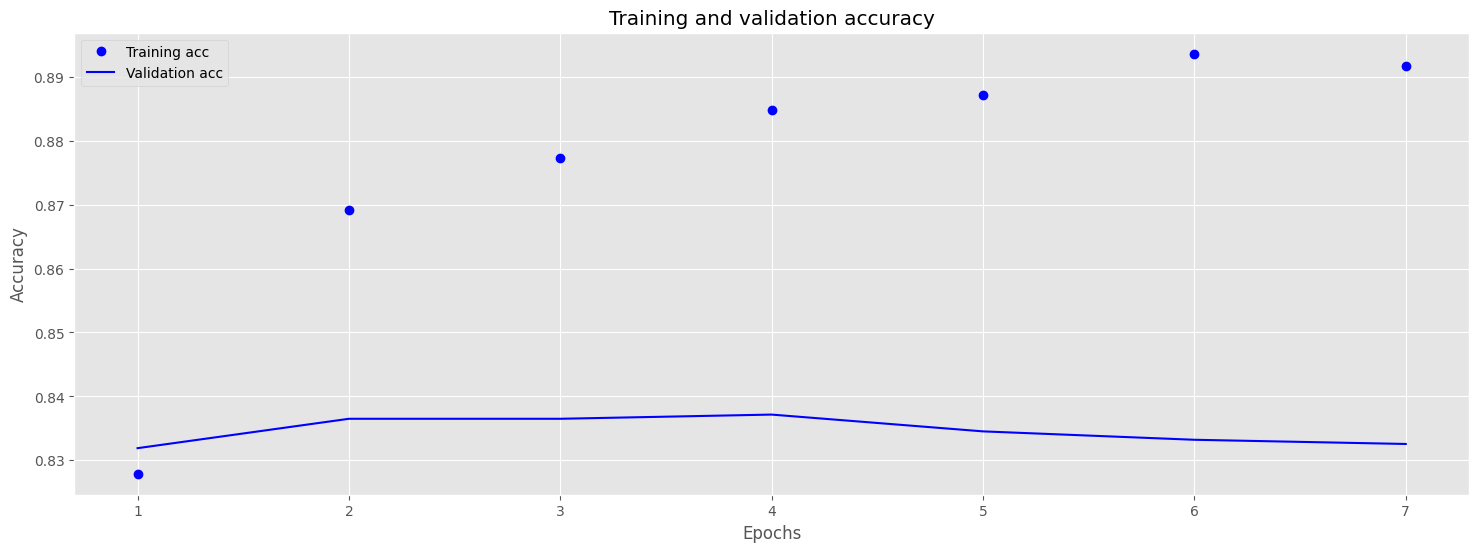

In [ ]:
plt.clf()
acc = history_dict["accuracy"]
val_acc = history_dict["val_accuracy"]
plt.plot(epochs, acc, "bo", label="Training acc")
plt.plot(epochs, val_acc, "b", label="Validation acc")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [ ]:
x_test = tokenizer(
    text=df_test.text.tolist(),
    add_special_tokens=True,
    max_length=max_length,
    truncation=True,
    padding=True, 
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = True,
    verbose = True)

In [ ]:
x_test['attention_mask']

<tf.Tensor: shape=(3263, 34), dtype=int32, numpy=
array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]], dtype=int32)>

In [ ]:
predicted = loaded_model.predict({'input_ids':x_test['input_ids'],'input_mask':x_test['attention_mask']})

102/102 [==============================] - 14s 107ms/step


In [ ]:
y_predicted = np.where(predicted>0.5,1,0)
y_predicted = y_predicted.reshape((1,3263))[0]
df_sample['id'] = df_test.id
df_sample['target'] = y_predicted
df_sample.to_csv('submission.csv',index = False)
# 리더보드 0.82929